In [1]:
import xarray as xr
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.stats import linregress

### Inputs

In [2]:
# Easymore SWE directory path
directory= 'easymore_snotel/'

# Define the start month and day of analysis
month = 4
day = 1

# define end month and day of analysis
end_month= 6
end_day= 30

# Path to HYPE observed flow 
qobs= '../esp_hype/model/Qobs.txt'

# HYPE river segment to be analyzed
riv_seg= '58213'

# Output image location
output_dir = './plots/'

### Get Upstream Segments

In [3]:
# Read the river and catchment shapefiles
gdf = gpd.read_file('smm_tgf_modified/smm_riv.shp')
catchment= gpd.read_file('smm_tgf_modified/smm_cat.shp')

In [4]:
# Create a dictionary from 'hru_nhm' and 'seg_nhm' columns in catchment
segment_dict = dict(zip(catchment['seg_nhm'], catchment['hru_nhm']))

In [5]:
# Convert columns to string data type
gdf['seg_nhm'] = gdf['seg_nhm'].astype(str)
gdf['ds_seg_nhm'] = gdf['ds_seg_nhm'].astype(str)

In [6]:
# Create a directed graph
riv_graph = nx.DiGraph()

# Add edges from DataFrame
for idx, row in gdf.iterrows():
    if row['ds_seg_nhm'] != '0':  # Skip if ds_seg_nhm is '0'
        riv_graph.add_edge(row['seg_nhm'], row['ds_seg_nhm'])

# Find upstream segments for given segment
upstream_segments = list(nx.ancestors(riv_graph, riv_seg))

# Add the target segment 'riv_seg' to the upstream segments
upstream_segments.append(riv_seg)

In [7]:
# Convert keys in segment_dict to integers
segment_dict = {int(k): v for k, v in segment_dict.items()}

# Convert values in upstream_segments to integers
upstream_segments = [int(seg) for seg in upstream_segments]

# Convert stream segments to hru IDs for comparison with snotel
upstream_segments = [segment_dict.get(seg, seg) for seg in upstream_segments]

### SWE

In [8]:
# Initialize an empty list to store results
results = []

In [9]:
# Loop through each .nc file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.nc'):
        # Read the dataset into xarray
        filepath = os.path.join(directory, filename)
        dataset = xr.open_dataset(filepath)
        
        # List to store total SWE for each upstream segment
        total_swe_list = []
        
        for seg in upstream_segments:            
            # Select the 'swe' variable and subset by ID
            subset_data = dataset['swe'].sel(ID=seg)

            # Convert the xarray DataArray to a pandas DataFrame
            df = subset_data.to_dataframe().reset_index()

            # Convert 'time' column to datetime format
            df['time'] = pd.to_datetime(df['time'])

            # Set 'time' column as index and drop 'ID' column
            df.set_index('time', inplace=True)
            df.drop(columns=['ID'], inplace=True)

            # Convert the index to datetime format if it's not already
            df.index = pd.to_datetime(df.index)
            
            # Create a mask for the specified month and day
            mask = (df.index.month == month) & (df.index.day == day)

            # Apply the mask to filter the DataFrame
            filtered_df = df.loc[mask]

            # Extract the 'SWE' value
            swe_value = filtered_df['swe'].values[0] if not filtered_df.empty else None

            # For total winter SWE
            # Create a mask for the specified month and day
            # mask = (df.index.month < month) | ((df.index.month == month) & (df.index.day <= day))

            # Apply the mask to filter the DataFrame
            #filtered_df = df.loc[mask]

            # Sum the 'SWE' values
           #total_swe = filtered_df['swe'].sum()
            
            # Append the total SWE to the list
            total_swe_list.append(swe_value)
        
        # Get the first date in the filtered DataFrame
        first_date = filtered_df.index.min()
 
        
        # Append the results to the final list
        results.append([filename, sum(total_swe_list), first_date])

In [10]:
# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Filename', 'Total_SWE', 'First_Date'])

In [11]:
# Add a new column 'Rank' to rank the 'Total_SWE' values from largest to smallest
results_df['SWE_Rank'] = results_df['Total_SWE'].rank(ascending=False).astype(int)

In [12]:
# Convert 'First_Date' column to only include the year
results_df['First_Date'] = results_df['First_Date'].dt.year

### Qobs

In [13]:
# Read qobs hype input to dataframe
df = pd.read_csv(qobs, sep='\t', index_col=0)

In [14]:
# Convert the index to datetime
df.index = pd.to_datetime(df.index)

# Change the headers to integers
df.columns = df.columns.astype(int)

In [15]:
# Drop all columns that are not equal to 'riv_seg'
df = df.loc[:, df.columns == int(riv_seg)]

In [17]:
# Create an empty DataFrame to store the results
qobs_df = pd.DataFrame(columns=['Year', 'Total_flow'])

# Iterate over unique years in the index
for year in df.index.year.unique():
    # Define start and end dates for filtering
    start_date = f"{year}-{month}-{day}"
    end_date = f"{year}-{end_month}-{end_day}"
    
    # Create a mask for the specified date range
    mask = (df.index >= start_date) & (df.index <= end_date)
    
    # Apply the mask to filter the DataFrame
    filtered_df = df.loc[mask]
    
    # Sum the summer streamflow values
    total_swe = filtered_df[int(riv_seg)].sum()
    
    # Append the results to the results DataFrame
    qobs_df = pd.concat([qobs_df, pd.DataFrame({'Year': [year], 'Total_flow': [total_swe]})], ignore_index=True)

In [18]:
# Rank the 'Total_flow' values from largest to smallest
qobs_df['Flow_Rank'] = qobs_df['Total_flow'].rank(ascending=False).astype(int)

In [19]:
# Merge results_df and qobs_df based on 'First_Date' and 'Year' columns
merged_df = pd.merge(results_df, qobs_df, left_on='First_Date', right_on='Year', how='inner')

# Drop the duplicate 'Year' column
merged_df.drop(columns=['Year'], inplace=True)

In [21]:
merged_df

,Filename,Total_SWE,First_Date,SWE_Rank,Total_flow,Flow_Rank
0,SMM_Snotel_remapped_4km_SWE_Depth_WY1982_v01.nc,7228.107513,1982,10,4005.264907,17
1,SMM_Snotel_remapped_4km_SWE_Depth_WY1983_v01.nc,5814.463837,1983,21,3132.047794,34
2,SMM_Snotel_remapped_4km_SWE_Depth_WY1984_v01.nc,4585.758118,1984,33,3146.988580,33
3,SMM_Snotel_remapped_4km_SWE_Depth_WY1985_v01.nc,6042.978302,1985,18,4324.496629,16
4,SMM_Snotel_remapped_4km_SWE_Depth_WY1986_v01.nc,5132.203400,1986,29,3992.282318,19
5,SMM_Snotel_remapped_4km_SWE_Depth_WY1987_v01.nc,5712.119385,1987,23,3705.367832,26
6,SMM_Snotel_remapped_4km_SWE_Depth_WY1988_v01.nc,4391.513168,1988,35,3372.216917,29
7,SMM_Snotel_remapped_4km_SWE_Depth_WY1989_v01.nc,6032.215790,1989,19,4545.456077,12
8,SMM_Snotel_remapped_4km_SWE_Depth_WY1990_v01.nc,6724.783051,1990,13,3993.918181,18
9,SMM_Snotel_remapped_4km_SWE_Depth_WY1991_v01.nc,8393.500397,1991,4,5703.674097,1


### Plot

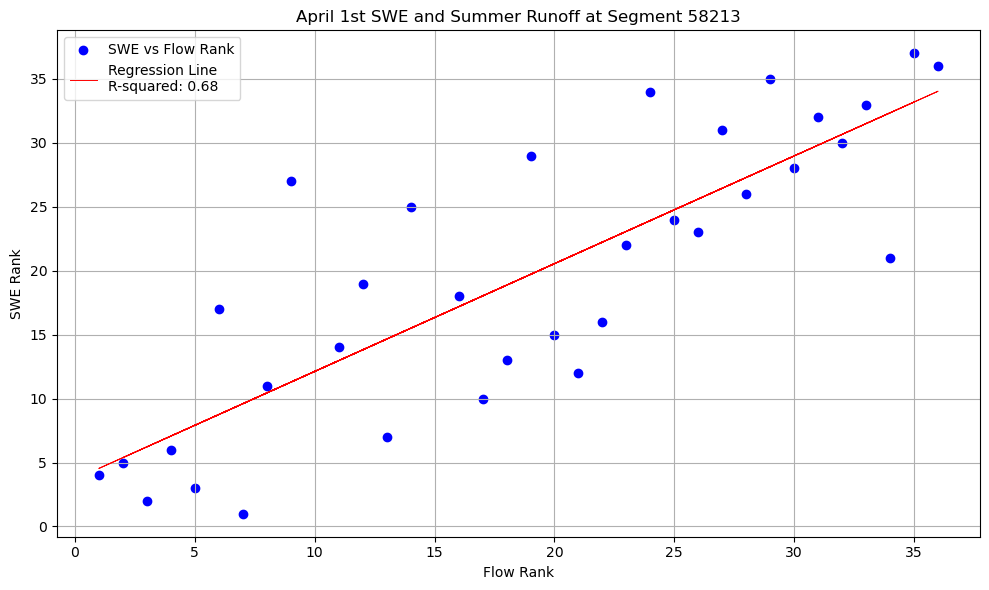

R-squared: 0.68


In [20]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Flow_Rank'], merged_df['SWE_Rank'], label='SWE vs Flow Rank', color='blue')

# Compute regression line
slope, intercept, r_value, p_value, std_err = linregress(merged_df['Flow_Rank'], merged_df['SWE_Rank'])
regression_line = slope * merged_df['Flow_Rank'] + intercept

# Plot regression line with thinner and dashed style
plt.plot(merged_df['Flow_Rank'], regression_line, color='red',  linewidth=0.7, label=f'Regression Line\nR-squared: {r_value**2:.2f}')

# Set plot title and labels
plt.title(f'April 1st SWE and Summer Runoff at Segment {riv_seg}')
plt.xlabel('Flow Rank')
plt.ylabel('SWE Rank')
plt.legend()
plt.grid(True)

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the plot as an image file
output_file_path = os.path.join(output_dir, f'{riv_seg}_SWEvsFlow')
plt.savefig(output_file_path, dpi=300)  # dpi specifies the resolution (dots per inch)

# Show plot
plt.tight_layout()
plt.show()

# Print R-squared value
print(f'R-squared: {r_value**2:.2f}')